In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score,classification_report,roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import xgboost as xgb
# from xgboost.sklearn import XGBClassifier

from scipy.stats import boxcox

import nltk
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from wordcloud import WordCloud

from joblib import dump, load
import pickle

import string
import re
import time

# pip install pandas-profiling 
# from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importing the dataset
data = pd.read_csv("../data/trainingdata.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1")
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
# Assigning proper column names to dataframe
data.columns = ["sentiment", "time", "date", "query", "username", "text"]
data.head()

,sentiment,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
# Checking the shape of the dataframe
data.shape

(1599999, 6)

In [8]:
# Checking the datatype, number of null values present
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   time       1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   query      1599999 non-null  object
 4   username   1599999 non-null  object
 5   text       1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
# Checking column wise to check for the presence of null values
data.isnull().sum()

sentiment    0
time         0
date         0
query        0
username     0
text         0
dtype: int64

In [10]:
# Checking the spread of values in the target variable
data['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

<AxesSubplot:>

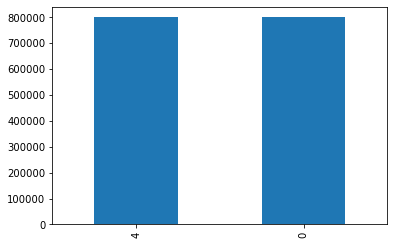

In [11]:
# Plotting the same in bar chart
data['sentiment'].value_counts().plot.bar()

In [12]:
# Considering the relevant columns in the final dataframe
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [13]:
# Converting the ppositive sentiment value "4" to "1" in the target variable for better understanding
data['sentiment'] = data['sentiment'].apply(lambda x : 1 if x == 4 else x)

In [14]:
# Checking the spread of values post change
data['sentiment'].value_counts()

1    800000
0    799999
Name: sentiment, dtype: int64

In [15]:
# Checking few rows in the dataframe
data.head()

,text,sentiment
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [16]:
# Storing text and sentiment data in lists for further processing
text, sentiment = list(data['text']), list(data['sentiment'])

In [17]:
def preprocess(textdata):
    
    # Defining dictionary containing all emojis with their meanings.
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

    stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
                 'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
                 'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
                 'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
                 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
                 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
                 'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
                 'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
                 'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
                 's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
                 't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
                 'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
                 'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
                 'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
                 "youve", 'your', 'yours', 'yourself', 'yourselves']


    processedText = []
        
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    # alphaPattern      = "[^a-zA-Z0-9]"
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])    
            
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  
        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        #Removing punctuations if any left post removing all all non alphabets
        all_char_list = []
        all_char_list = [char for char in tweet if char not in string.punctuation]
        tweet = ''.join(all_char_list)
        
        # Removing all stopwords as per custom list defined above
        tweetwords = ''
        for word in tweet.split():
            if word not in (stopwordlist):
                if len(word)>1:
                    # Lemmatizing the word.
                    # text_pos = pos_tag(word_tokenize(word))
                    # word = lemma.lemmatize(text_pos[0][0],get_wordnet_pos_tag(text_pos[0][1]))
                    # word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [18]:
# Applying the entire text stored in list "text" for preprocessing and calculating the time taken to perform the operation
t = time.time()
preprocessedtext = preprocess(text)
print('Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 148 seconds


In [19]:
# Defining a method to return the 2nd parameter for lemmatization that is POS tag
def get_wordnet_pos_tag(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [20]:
# Created a method to perform lemmatization with POS tags identified via a pos_tag method
def lemmatize_process(preprocessedtext):
    # Create Lemmatizer
    lemma = WordNetLemmatizer()
    
    finalprocessedtext = []
    for tweet in preprocessedtext:
        text_pos = pos_tag(word_tokenize(tweet))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        tweet_lemma = " ".join([lemma.lemmatize(a,get_wordnet_pos_tag(b)) for a,b in zip(words,pos)])
        finalprocessedtext.append(tweet_lemma)
    return finalprocessedtext

In [22]:
# Applying the entire text stored in list "text" for preprocessing and calculating the time taken to perform the operation
t = time.time()
processedtext = lemmatize_process(preprocessedtext)
print('Text Lemmatization complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Lemmatization complete.
Time Taken: 1561 seconds


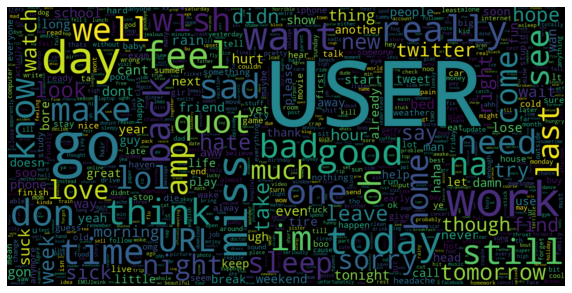

In [23]:
# Creating word cloud of negative tweets, where the words appearing larger are more frequent in nature across articles
# First 800000 tweets in the list are negative tweets

data_neg = processedtext[:800000]
all_negwords = ' '.join(data_neg)
wordcloud = WordCloud(max_words = 1000, width= 1600, height= 800,
                      collocations = False).generate(all_negwords)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

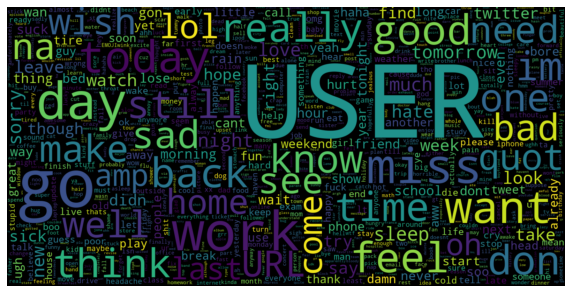

In [24]:
# Creating word cloud of positive tweets, where the words appearing larger are more frequent in nature acros articles
# Last 800000 tweets in the list are negative tweets

data_pos = processedtext[800000:]
all_poswords = ' '.join(data_pos)
wordcloud = WordCloud(max_words = 1000, width= 1600, height= 800,
                      collocations = False).generate(all_negwords)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
# Created a method using WhitespaceTokenizer and FreqDist to identify the most frequent set of words in the datset segregated
# by target variable

token_wspace = tokenize.WhitespaceTokenizer()

def mostFrequentWords(tweets,quantity):
    all_words = ' '.join(tweets)
    all_tokens = token_wspace.tokenize(all_words)
    freq_dist = nltk.FreqDist(all_tokens)
    df_frequency = pd.DataFrame({"Word":list(freq_dist.keys()), "Frequency":list(freq_dist.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

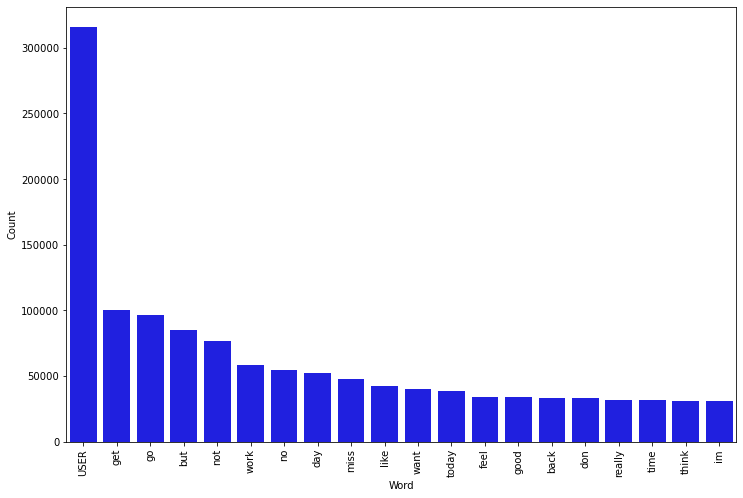

In [26]:
# Calling the above method for negative cases, plotting the most frequent top 10 words
mostFrequentWords(processedtext[:800000],20)

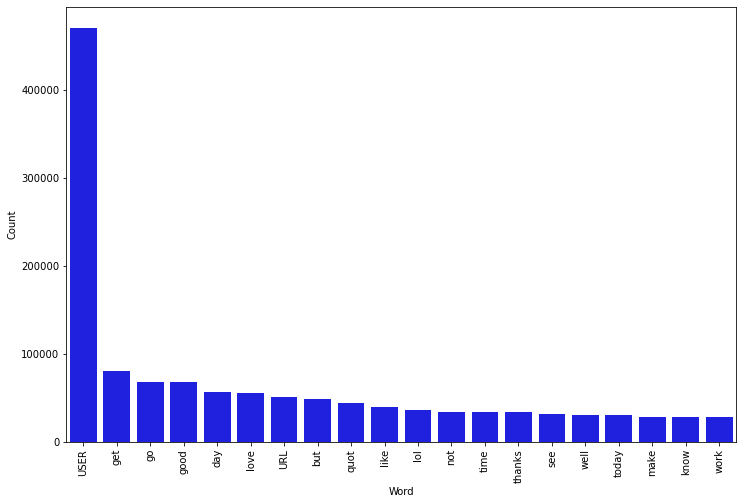

In [27]:
# Calling the above method for positive cases, plotting the most frequent top 10 words
mostFrequentWords(processedtext[800000:],20)

In [28]:
# Splitting the entire set into train and test with test size of 5%
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done..')

Data Split done..


In [29]:
# Fitting TFIDF vectorizer on the train dataset 
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [30]:
# Transforming the X_train and X_test dataset on the fitted model
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [31]:
# Creating a method which will take the model object and then predict on the test set and evaluate on Accuracy, 
# Confusion Matrix and ROC Curve

def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    
    plt.title ("ROC Curve")
    #Area under Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     39986
           1       0.79      0.81      0.80     40014

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



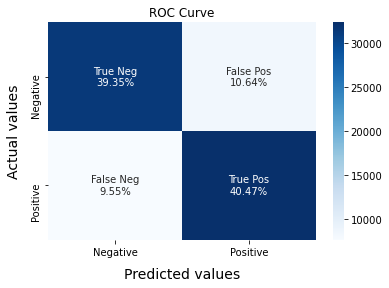

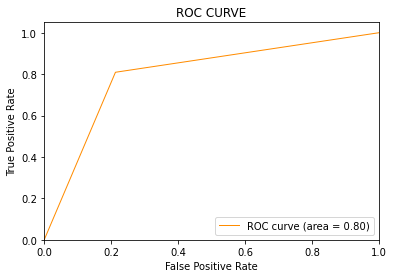

array([1, 1, 0, ..., 1, 1, 1])

In [32]:
# Created a Linear SVM model with default parameters and then evaluating the model

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     39986
           1       0.79      0.80      0.80     40014

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



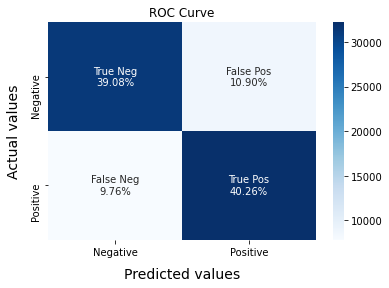

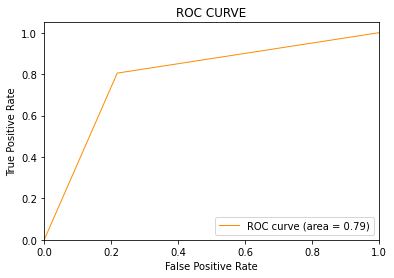

array([1, 1, 0, ..., 1, 1, 0])

In [33]:
# Created a Bernoulli Naive Bayes model with default parameters and then evaluating the model

BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39986
           1       0.81      0.82      0.81     40014

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



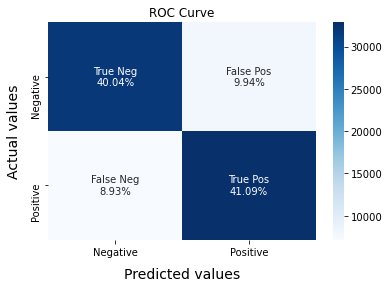

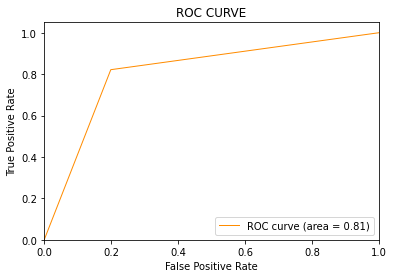

In [34]:
# Created a Logistic Regression model with regularization parameter and max iteration limit and then evaluating the model
LRmodel = LogisticRegression(C = 1, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_test_pred = model_Evaluate(LRmodel)

In [35]:
# Printing the positive and negative sentiment on the test data based on logistic regression model
print("Positive Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 1)/len(y_test_pred)*100,2)))

print("Negative Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 0)/len(y_test_pred)*100,2)))

Positive Sentiment Percentage : 51.03%
Negative Sentiment Percentage : 48.97%


In [36]:
# Storing the vectorizer object and Logistic Regression object in pickle files for later use

file = open('../models/vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('../models/Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

In [37]:
# Created a method to load the models from pickle file
def load_models():  
       
    # Load the vectoriser.
    file = open('../models/vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('../models/Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel


# Created a method to perform tfidf vectorizer on unseen data and then using the model loaded from pickle file to predict 
# whether positive or negative and also the probability along with it.
# Do note the unseen data should be passed to the model in a list
def predict(vectoriser, model, text):
    finaldata = []

    textdata = vectoriser.transform(lemmatize_process(preprocess(text)))
    sentiment = model.predict(textdata)
    
    
    sentiment_prob = model.predict_proba(textdata)
    
    for index,tweet in enumerate(text):
        if sentiment[index] == 1:
            sentiment_probFinal = sentiment_prob[index][1]
        else:
            sentiment_probFinal = sentiment_prob[index][0]
            
        sentiment_probFinal2 = "{}%".format(round(sentiment_probFinal*100,2))
        finaldata.append((tweet, sentiment[index], sentiment_probFinal2))
    
    df = pd.DataFrame(finaldata, columns = ['tweet','sentiment', 'Probability(Confidence Level)'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [67]:
# Text to classify should be in a list.
text = ["I hate twitter",
        "I do not like the movie",
        "Mr. Stark, I don't feel so good",
        "May the Force be with you.",
       "I read the book, the content is not good",
       "This is a new beginning for us","abhinav is not bad"]

In [68]:
vectoriser, LRmodel = load_models()
df = predict(vectoriser, LRmodel, text)
df

,tweet,sentiment,Probability(Confidence Level)
0,I hate twitter,Negative,93.13%
1,I do not like the movie,Negative,80.68%
2,"Mr. Stark, I don't feel so good",Negative,68.99%
3,May the Force be with you.,Positive,66.73%
4,"I read the book, the content is not good",Negative,67.22%
5,This is a new beginning for us,Positive,79.99%
6,abhinav is not bad,Positive,86.99%


In [39]:
# Importing the dataset
data = pd.read_csv("../data/testdata.csv", encoding = "ISO-8859-1")
data.head()

,url,date,text
0,https://twitter.com/EcoLisa_/status/9022754290...,Mon Aug 28 21:03:20 2017,Here's how you can help victims of #HurricaneH...
1,https://twitter.com/RedefiningDecor/status/903...,Thu Aug 31 15:43:15 2017,RT @tripgabriel: This is a very gripping graph...
2,https://twitter.com/BestofY00/status/903281998...,Thu Aug 31 15:43:05 2017,RT @tripgabriel: This is a very gripping graph...
3,https://twitter.com/Deborah9111966/status/9032...,Thu Aug 31 15:43:01 2017,RT @tripgabriel: This is a very gripping graph...
4,https://twitter.com/kirkbocchi/status/90328194...,Thu Aug 31 15:42:53 2017,RT @tripgabriel: This is a very gripping graph...


In [41]:
data.shape

(15428, 3)

In [42]:
text = list(data['text'])

In [43]:
def predict_Excel(vectoriser, model, text):
    finaldata = []

    textdata = vectoriser.transform(lemmatize_process(preprocess(text)))
    sentiment = model.predict(textdata)
    
    # print(model.classes_)
    sentiment_prob = model.predict_proba(textdata)
    
    for index,tweet in enumerate(text):
        sentiment_probFinal = sentiment_prob[index][0]
            
        sentiment_probFinal2 = "{}%".format(round(sentiment_probFinal*100,2))
        finaldata.append((tweet, sentiment[index], sentiment_probFinal2))
           
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(finaldata, columns = ['tweet','sentiment', 'Severity'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [44]:
vectoriser, LRmodel = load_models()
df = predict_Excel(vectoriser, LRmodel, text)

In [45]:
df.sort_values(by=['Severity'],ascending=False,inplace=True)
df

,tweet,sentiment,Severity
6888,When the storm comes it affects us all...no ex...,Negative,99.61%
9121,It's Sad That Some Hispanics In Houston Have T...,Negative,99.54%
2009,This breaks my heart. I wish I could do more t...,Negative,99.53%
18,This is so sad. Thousands Cried for Help as Ho...,Negative,99.3%
9794,Sad and scary situation in Houston https://t.c...,Negative,99.12%
...,...,...,...
9549,RT @PRyan: Thank you @JJWatt. You make Wiscons...,Positive,0.98%
9606,RT @PRyan: Thank you @JJWatt. You make Wiscons...,Positive,0.98%
9676,RT @PRyan: Thank you @JJWatt. You make Wiscons...,Positive,0.98%
1477,Good morning #SPNFamily I'm so proud of us Ke...,Positive,0.92%


63.97 %
36.03 %


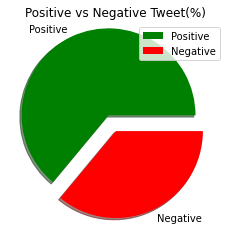

In [52]:
positive = round(np.count_nonzero(df['sentiment'] == "Positive")/len(df['sentiment'])*100,2)
negative = round(np.count_nonzero(df['sentiment'] == "Negative")/len(df['sentiment'])*100,2)
print(positive,"%")
print(negative,"%")

labels = ['Positive','Negative']
values = np.array([positive,negative])
myexplode = [0.2, 0]
mycolors = ["green", "red"]

fig,ax = plt.subplots()
ax.pie(values, labels = labels, explode = myexplode, shadow = True, colors = mycolors)
ax.legend()
ax.set_title("Positive vs Negative Tweet(%)")
fig.show()

In [47]:
filename = 'Final.csv'
df.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: Final.csv
